In [2]:
import nltk  # Natural language processing library
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization

from nltk.corpus import stopwords  # Stopword removal
from nltk.sentiment import SentimentIntensityAnalyzer  # Sentiment analysis
from sklearn.ensemble import RandomForestClassifier  # Machine learning classifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # Text feature extraction
from sklearn.linear_model import LogisticRegression  # Logistic regression classifier
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import classification_report  # Model evaluation report
from sklearn.model_selection import cross_val_score, train_test_split  # Model evaluation and dataset splitting
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics
from textblob import Word, TextBlob  # Text preprocessing and sentiment analysis
from wordcloud import WordCloud  # Word cloud visualization
from nltk import word_tokenize  # Tokenization of text


In [3]:
# Display all columns in the DataFrame without truncation
pd.set_option("display.max_columns", None)

# Set the display width to 200 characters to improve readability
pd.set_option("display.width", 200)

# Format floating-point numbers to display with two decimal places
pd.set_option("display.float_format", lambda x: "%.2f" % x)


In [4]:
df_train = pd.read_csv("twitter_training.csv")
df_valid = pd.read_csv("twitter_validation.csv")


In [5]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
df_train.columns

Index(['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,'], dtype='object')

In [7]:
# Renaming the columns of the training dataset for better readability and consistency
df_train.columns = ['id', 'information', 'status', 'comment']

# Displaying the first few rows of the training dataset to verify changes
df_train.head()


,id,information,status,comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
# Renaming the columns of the validation dataset to maintain consistency with the training dataset
df_valid.columns = ['id', 'information', 'status', 'comment']

# Displaying the first few rows of the validation dataset to verify changes
df_valid.head()


,id,information,status,comment
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74681 non-null  int64 
 1   information  74681 non-null  object
 2   status       74681 non-null  object
 3   comment      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           999 non-null    int64 
 1   information  999 non-null    object
 2   status       999 non-null    object
 3   comment      999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [11]:
# Check for missing values
missing_values = df_train.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 id               0
information      0
status           0
comment        686
dtype: int64


In [12]:
# Removing rows from the training dataset where the 'comment' column has missing (NaN) values
df_train = df_train.dropna(subset=['comment'])


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           73995 non-null  int64 
 1   information  73995 non-null  object
 2   status       73995 non-null  object
 3   comment      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


#### Normalizing Case Folding

In [14]:
# Converting all text in the 'comment' column of the training dataset to lowercase 
# This helps in standardizing the text and improving NLP model performance
df_train["comment"] = df_train["comment"].str.lower()

# Converting all text in the 'comment' column of the validation dataset to lowercase 
# Ensuring consistency across datasets for better text processing
df_valid["comment"] = df_valid["comment"].str.lower()


#### Punctuations, Urls and other Preprocessing

In [15]:
# Removing mentions (@username), ampersand labels (&labels), and standalone ampersands
# Removing URLs (both http/https and www-based)
# Removing numbers, punctuation, and extra spaces for better text processing

"""
Preprocessing Steps:
- [@&]\S+  → Removes @mentions and &labels
- &        → Removes standalone ampersands
- http\S+|www\S+ → Removes URLs
- \d+      → Removes numbers
- [^\w\s]  → Removes all punctuation
- \s+      → Removes extra spaces
- .str.strip() → Removes leading and trailing spaces
"""

# Applying the preprocessing steps to the 'comment' column in the training dataset
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True) \
                                        .str.replace(r"\s+", " ", regex=True) \
                                        .str.strip()

# Applying the same preprocessing steps to the 'comment' column in the validation dataset
df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|[^\w\s]", "", regex=True) \
                                        .str.replace(r"\s+", " ", regex=True) \
                                        .str.strip()

# Additionally removing numbers in both datasets
df_train["comment"] = df_train["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                        .str.replace(r"\s+", " ", regex=True) \
                                        .str.strip()

df_valid["comment"] = df_valid["comment"].str.replace(r"[@&]\S+|&|http\S+|www\S+|\d+|[^\w\s]", "", regex=True) \
                                        .str.replace(r"\s+", " ", regex=True) \
                                        .str.strip()


<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ARC TMG\AppData\Local\Temp\ipykernel_2852\563158794.py:5: SyntaxWarning: invalid escape sequence '\S'
  """


#### Stopwords

In [16]:
# Download the NLTK stopwords dataset (only required once)
nltk.download("stopwords")

# Import the stopwords module from NLTK
from nltk.corpus import stopwords

# Retrieve the list of English stopwords
sw = stopwords.words("english")


[nltk_data] Downloading package stopwords to C:\Users\ARC
[nltk_data]     TMG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Remove stopwords from the "comment" column in the training dataset
df_train["comment"] = df_train["comment"].apply(
    lambda x: " ".join(word for word in str(x).split() if word not in sw)
)

# Remove stopwords from the "comment" column in the validation dataset
df_valid["comment"] = df_valid["comment"].apply(
    lambda x: " ".join(word for word in str(x).split() if word not in sw)
)



#### Rarewords

In [18]:
# Merge all comments into a single string, split into words, and count occurrences (Training dataset)
temp_df_train = pd.Series(" ".join(df_train["comment"]).split()).value_counts()

# Merge all comments into a single string, split into words, and count occurrences (Validation dataset)
temp_df_valid = pd.Series(" ".join(df_valid["comment"]).split()).value_counts()


In [19]:
temp_df_train

game                   8066
im                     4941
like                   4882
get                    3941
one                    3584
                       ... 
nvidiadoesnt              1
maxbitcc                  1
netcomgooglechallen       1
challen                   1
techsall                  1
Name: count, Length: 37334, dtype: int64

In [20]:
# Identify rare words in the training dataset (words that appear once or less)
drop_train = temp_df_train[temp_df_train <= 1]

# Identify rare words in the validation dataset (words that appear once or less)
drop_valid = temp_df_valid[temp_df_valid <= 1]


In [21]:
# Remove specific words from the "comment" column in the training dataset
df_train["comment"] = df_train["comment"].apply(
    lambda x: " ".join(x for x in x.split() if x not in drop_train)
)

# Remove specific words from the "comment" column in the validation dataset
df_valid["comment"] = df_valid["comment"].apply(
    lambda x: " ".join(x for x in x.split() if x not in drop_valid)
)


In [22]:
df_train.head(10)

,id,information,status,comment
0,2401,Borderlands,Positive,coming borders kill
1,2401,Borderlands,Positive,im getting borderlands kill
2,2401,Borderlands,Positive,im coming borderlands murder
3,2401,Borderlands,Positive,im getting borderlands murder
4,2401,Borderlands,Positive,im getting borderlands murder
5,2402,Borderlands,Positive,spent hours making something fun dont know hug...
6,2402,Borderlands,Positive,spent couple hours something fun dont know im ...
7,2402,Borderlands,Positive,spent hours something fun dont know im huge bo...
8,2402,Borderlands,Positive,spent hours making something fun dont know hug...
9,2402,Borderlands,Positive,spent hours making something fun dont know hug...


In [23]:
# Count the number of occurrences of each category by "information" and "status"
plot1 = df_train.groupby(by=["information", "status"]).count().reset_index()

# Display the first few rows of the resulting DataFrame
plot1.head()


,information,status,id,comment
0,Amazon,Irrelevant,186,186
1,Amazon,Negative,575,575
2,Amazon,Neutral,1207,1207
3,Amazon,Positive,308,308
4,ApexLegends,Irrelevant,192,192


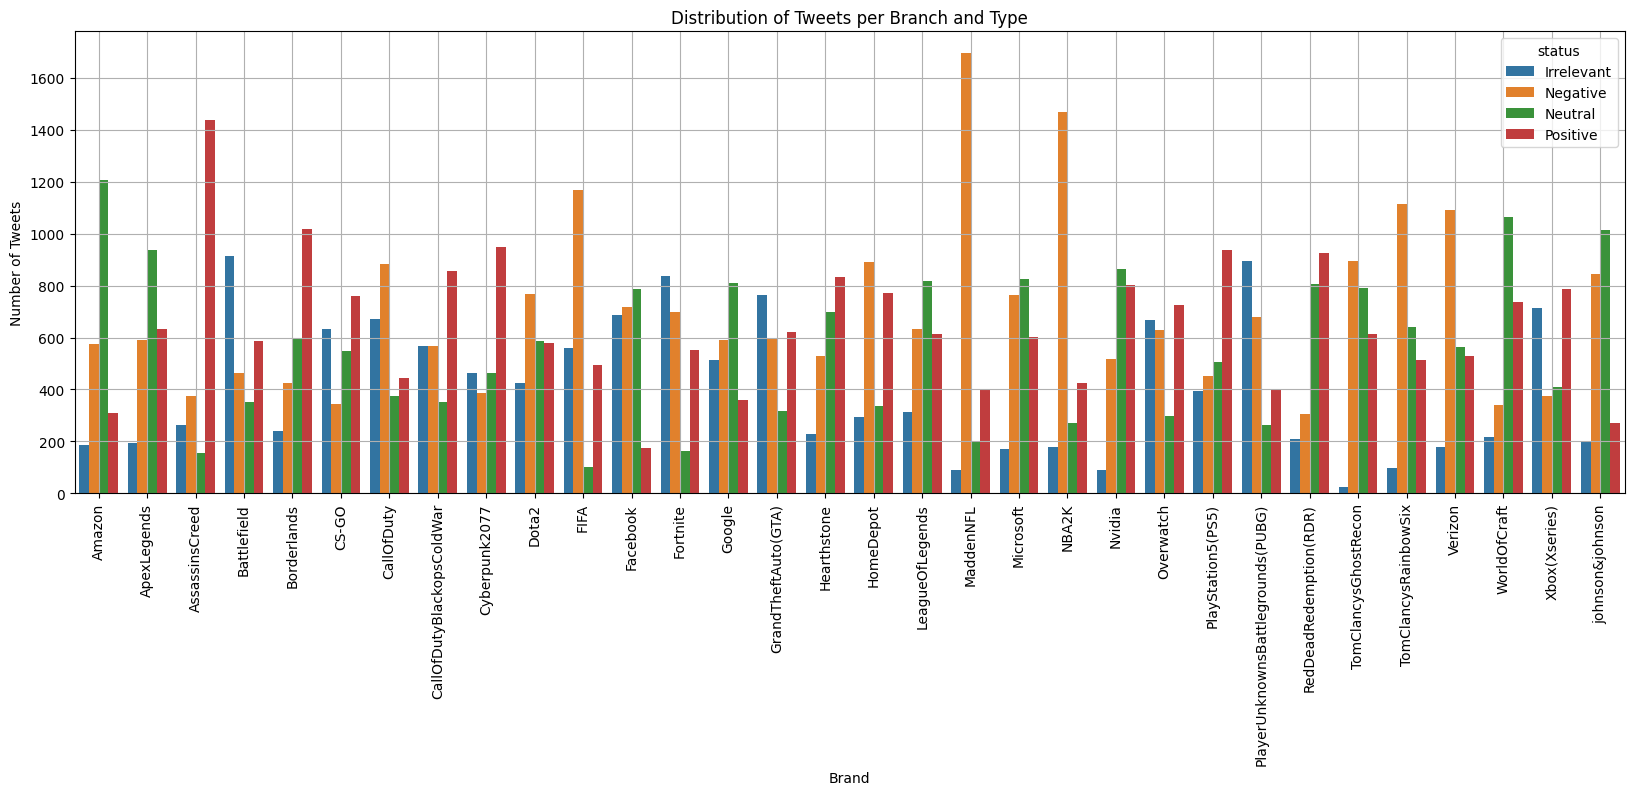

In [24]:
# Create a figure for comparing tweet distribution across branches
plt.figure(figsize=(20,6))  # Set figure size for better readability

# Create a bar plot showing the number of tweets per "information" category, grouped by "status"
sns.barplot(data=plot1, x="information", y="id", hue="status")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Set labels for x and y axes
plt.xlabel("Brand")  # Represents different categories of "information"
plt.ylabel("Number of Tweets")  # Represents tweet count

# Add grid lines for better visualization
plt.grid()

# Set the title of the plot
plt.title("Distribution of Tweets per Branch and Type");


C:\Users\ARC TMG\AppData\Local\Temp\ipykernel_2852\3438626753.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df_train, palette='viridis')


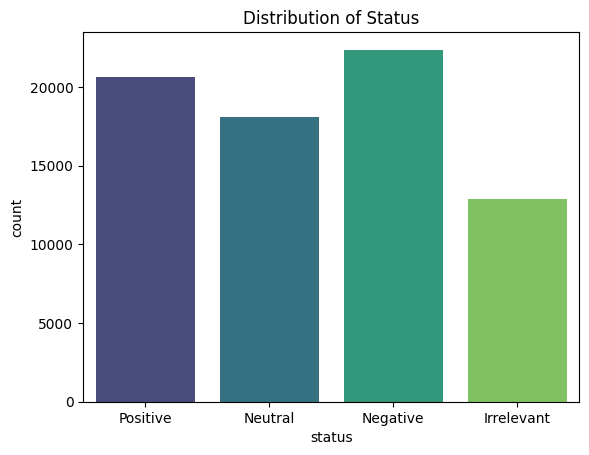

In [25]:
# Create a count plot to visualize the distribution of sentiments (status)
sns.countplot(x='status', data=df_train, palette='viridis')

# Set the title of the plot
plt.title("Distribution of Status")

# Display the plot
plt.show()


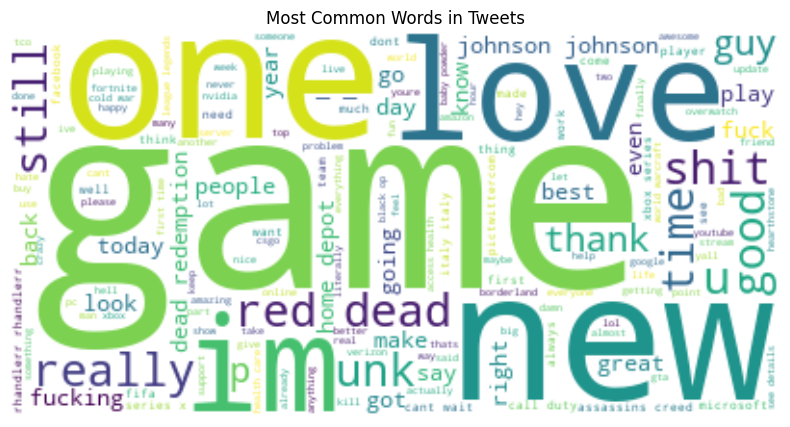

In [26]:
# Combine all comments into a single string for word cloud generation
text = " ".join(i for i in df_train.comment)

# Generate a word cloud with a white background
wordcloud = WordCloud(background_color="white").generate(text)

# Set figure size for better visualization
plt.figure(figsize=(12,5))

# Display the generated word cloud image
plt.imshow(wordcloud, interpolation="bilinear")

# Set the title of the plot
plt.title("Most Common Words in Tweets")

# Remove axis labels for a cleaner look
plt.axis("off")

# Show the word cloud
plt.show()


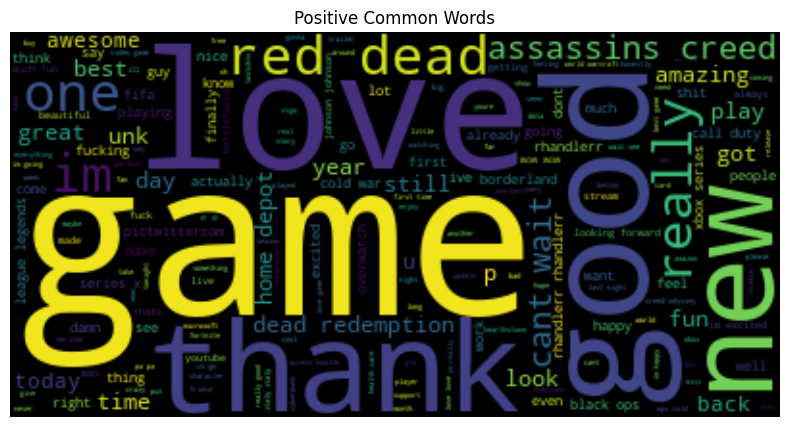

In [27]:
# Filter comments labeled as "Positive"
positive_comments = df_train[df_train["status"] == "Positive"]["comment"]

# Combine all positive comments into a single string for word cloud generation
text_positive = ' '.join(i for i in positive_comments)

# Generate a word cloud with a black background for positive words
wordcloud = WordCloud(background_color="black").generate(text_positive)

# Set figure size for better visualization
plt.figure(figsize=(10,5))

# Display the generated word cloud image
plt.imshow(wordcloud, interpolation="bilinear")

# Set the title of the plot
plt.title("Positive Common Words")

# Remove axis labels for a cleaner look
plt.axis("off")

# Show the word cloud
plt.show()


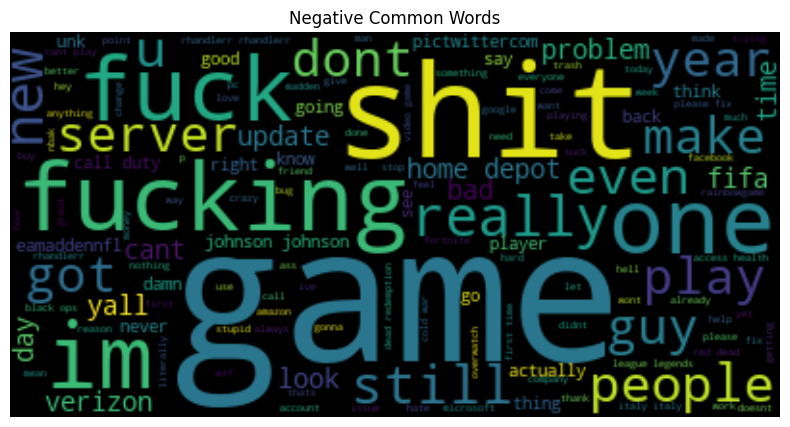

In [28]:
# Filter comments labeled as "Negative"
negative_comments = df_train[df_train["status"] == "Negative"]["comment"]

# Combine all negative comments into a single string for word cloud generation
text_negative = ' '.join(i for i in negative_comments)

# Generate a word cloud with a black background for negative words
wordcloud = WordCloud(background_color="black").generate(text_negative)

# Set figure size for better visualization
plt.figure(figsize=(10,5))

# Display the generated word cloud image
plt.imshow(wordcloud, interpolation="bilinear")

# Set the title of the plot
plt.title("Negative Common Words")

# Remove axis labels for a cleaner look
plt.axis("off")

# Show the word cloud
plt.show()


In [29]:
# Tokenize each comment in the "comment" column of the training dataset
tokens_text = [word_tokenize(str(word)) for word in df_train["comment"]]

# Flatten the list of lists to get a single list of all tokens
tokens_counter = [item for sublist in tokens_text for item in sublist]

# Print the number of unique tokens
print("Number of unique tokens: ", len(set(tokens_counter)))


Number of unique tokens:  25780


In [30]:
# Convert text data into numerical features using CountVectorizer
vectorizer = CountVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2))  
X = vectorizer.fit_transform(df_train['comment'])  # Transform comments into feature vectors
y = df_train['status']  # Target variable (sentiment labels)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize and train a Logistic Regression classifier
model = LogisticRegression(max_iter=200)  # Set max iterations to 200 for better convergence
model.fit(X_train, y_train)  # Train the model on training data

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))  # Print accuracy score
print(classification_report(y_test, y_pred))  # Print precision, recall, and F1-score


c:\Users\ARC TMG\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 